# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 28.02.2024

Мягкий дедлайн: 19.03.2024 23:59 MSK

Жёсткий дедлайн: 25.03.2024 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке

In [4]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import log1p

from scipy.special import expit as sigmoid
from scipy.special import logsumexp
from scipy.special import softmax
from scipy.optimize import check_grad

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import glob, gzip
import xml.etree.ElementTree as ET
from preprocessing import extract_sentences
from metrics import compute_aer

seed = 0xDEADF00D
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [3]:
L = np.load('L.npy')
n, m = L.shape

## **Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [4]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [5]:
class EM_Algorithm:
    def __init__(self, L:np.ndarray, lr: float=1e-3, n_steps: int=1000):
        self.L = L #(n_problems, n_experts)
        self.n_problems, self.n_experts = L.shape
        self.lr = lr
        self.n_steps = n_steps
        self.alpha = np.random.randn(self.n_experts) #(n_experts, )
        self.logbeta = np.random.randn(self.n_problems)#(n_problems, )
        self.beta = np.exp(self.logbeta)
        self.q = np.ones((2, self.n_problems)) * 0.5

        # ниже общие переменные, которые будут пересчитываться лишь раз за итерацию алгоритма
        # (в предложенной шаблоном структуре эти переменные пересчитывались бы несколько раз)
        self.outer = None
        self.S_pos = None
        self.S_neg = None
        self.M_0 = None
        self.M_1 = None

    def update_commons(self):
        """
        Updates common model parameters while fitting
        """
        self.outer = np.outer(self.beta, self.alpha)
        self.S_pos = sigmoid(self.outer)
        self.S_neg = sigmoid(-self.outer)
        self.M_0 = self.S_neg * (1 - self.L) - self.S_pos * self.L
        self.M_1 = self.S_neg * self.L - self.S_pos * (1 - self.L)

    def calc_gamma(self):
        """ Stable auxilary function for calculating posterior. 
        Uses -sofplus(-...) instead of log(sigmoid(...))
        Args:
            alpha: ndarray of shape (n_experts).
            beta: ndarray of shape (n_problems).
            L: binary ndarray of shape (n_problems, n_experts).
        Returns: gamma for future transformation to q = softmax(gamma): ndarray of shape (2, n_problems)
        """
        pos, neg = softplus(self.outer), softplus(-self.outer) # (n_problems, n_experts)

        gamma_0 = np.log(0.5) + np.sum((1-L) * (-neg) + L*(-pos), axis=1)
        gamma_1 = np.log(0.5) + np.sum(L * (-neg) + (1-L) * (-pos), axis=1)

        return np.vstack((gamma_0, gamma_1))

    def posterior(self):
        """ Posterior over true labels z p(z = 1|l, alpha, beta)
        Args:
            alpha: ndarray of shape (n_experts).
            beta: ndarray of shape (n_problems).
            L: ndarray of shape (n_problems, n_experts).
        Returns: q - posterior distribution of z: ndarray of shape (2, n_problems)
        """
        gamma = self.calc_gamma()
        return softmax(gamma, axis=0)
    
    def calc_grad(self):
        """Calculates both gradients simultaneously.
        Note that dl/dlog(b) = dl/db * b
        Returns: gradient of E(log-likelihood) wrt to alpha and log(beta)
        """
        grad_alpha = np.dot(self.M_0.T, self.q[0] * self.beta) + np.dot(self.M_1.T, self.q[1] * self.beta)
        grad_logbeta = (np.dot(self.M_0, self.alpha) * self.q[0] + np.dot(self.M_1, self.alpha) * self.q[1]) * self.beta
        return grad_alpha, grad_logbeta

    def alpha_grad_lb(self):
        return np.dot(self.M_0.T, (self.q[0] * self.beta)) + np.dot(self.M_1.T, (self.q[1] * self.beta))
    
    def logbeta_grad_lb(self):
        return (np.dot(self.M_0, self.alpha) * self.q[0] + np.dot(self.M_1, self.alpha) * self.q[1]) * self.beta

    def fit(self):
        for _ in range(self.n_steps):
            self.update_commons()
            self.q = self.posterior()

            grad_alpha, grad_logbeta = self.calc_grad()
            self.alpha += self.lr * grad_alpha
            self.logbeta += self.lr * grad_logbeta

            self.beta = np.exp(self.logbeta)
            
        return self.alpha, np.exp(self.logbeta), self.q
    
    def accuracy(self, y_true):
        if accuracy_score(y_true, np.argmax(self.q, axis=0)) >= 0.5:
            return accuracy_score(y_true, np.argmax(self.q, axis=0))
        else:
            return accuracy_score(y_true, np.argmin(self.q, axis=0))

In [10]:
model = EM_Algorithm(L, lr=1e-3, n_steps=1000)

alpha, beta, q = model.fit()

## **Задание 2. (1 балл)** Загрузите настоящую разметку. 
Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$). 

In [11]:
y = np.load('y.npy')

print(f'Accuracy EM-алгоритма:{model.accuracy(y)}')

print(f'Accuracy голосования большинством: {accuracy_score((L.mean(axis=1) > 0.5).astype(int), y)}')

Accuracy EM-алгоритма:0.9555
Accuracy голосования большинством: 0.904


Хобаааа! Мой EM лучше голосования большинством! Значит мы хорошо детектим обманщиков

## **Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$.
 Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли верно размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

Если альфы сильно меньше нуля, то эксперта нужно считать плохим, поскольку это означает, что он неправильно угадывает лёгкие картинки: при $1/\beta_i \rightarrow 0$ для таких экспертов $$p(l_{ij} = z_i | z_i, \alpha_j, \beta_i) = \sigma (\alpha_j \beta_i) \rightarrow 0$$
Посмотрим, как обычно голосуют эксперты:

In [12]:
#accuracy для каждого эксперта
exp_accuracies = (L == np.repeat(y, 20).reshape(2000, 20)).mean(axis=0)

print(f'Из 40000 правильных отметок {np.sum(L == np.repeat(y, 20).reshape(2000, 20))}')

Из 40000 правильных отметок 25456


То есть эксперты всё-таки чаще голосуют за верный класс, однако не слишком часто. Теперь посмотрим, есть ли у нас обманщики (они есть):

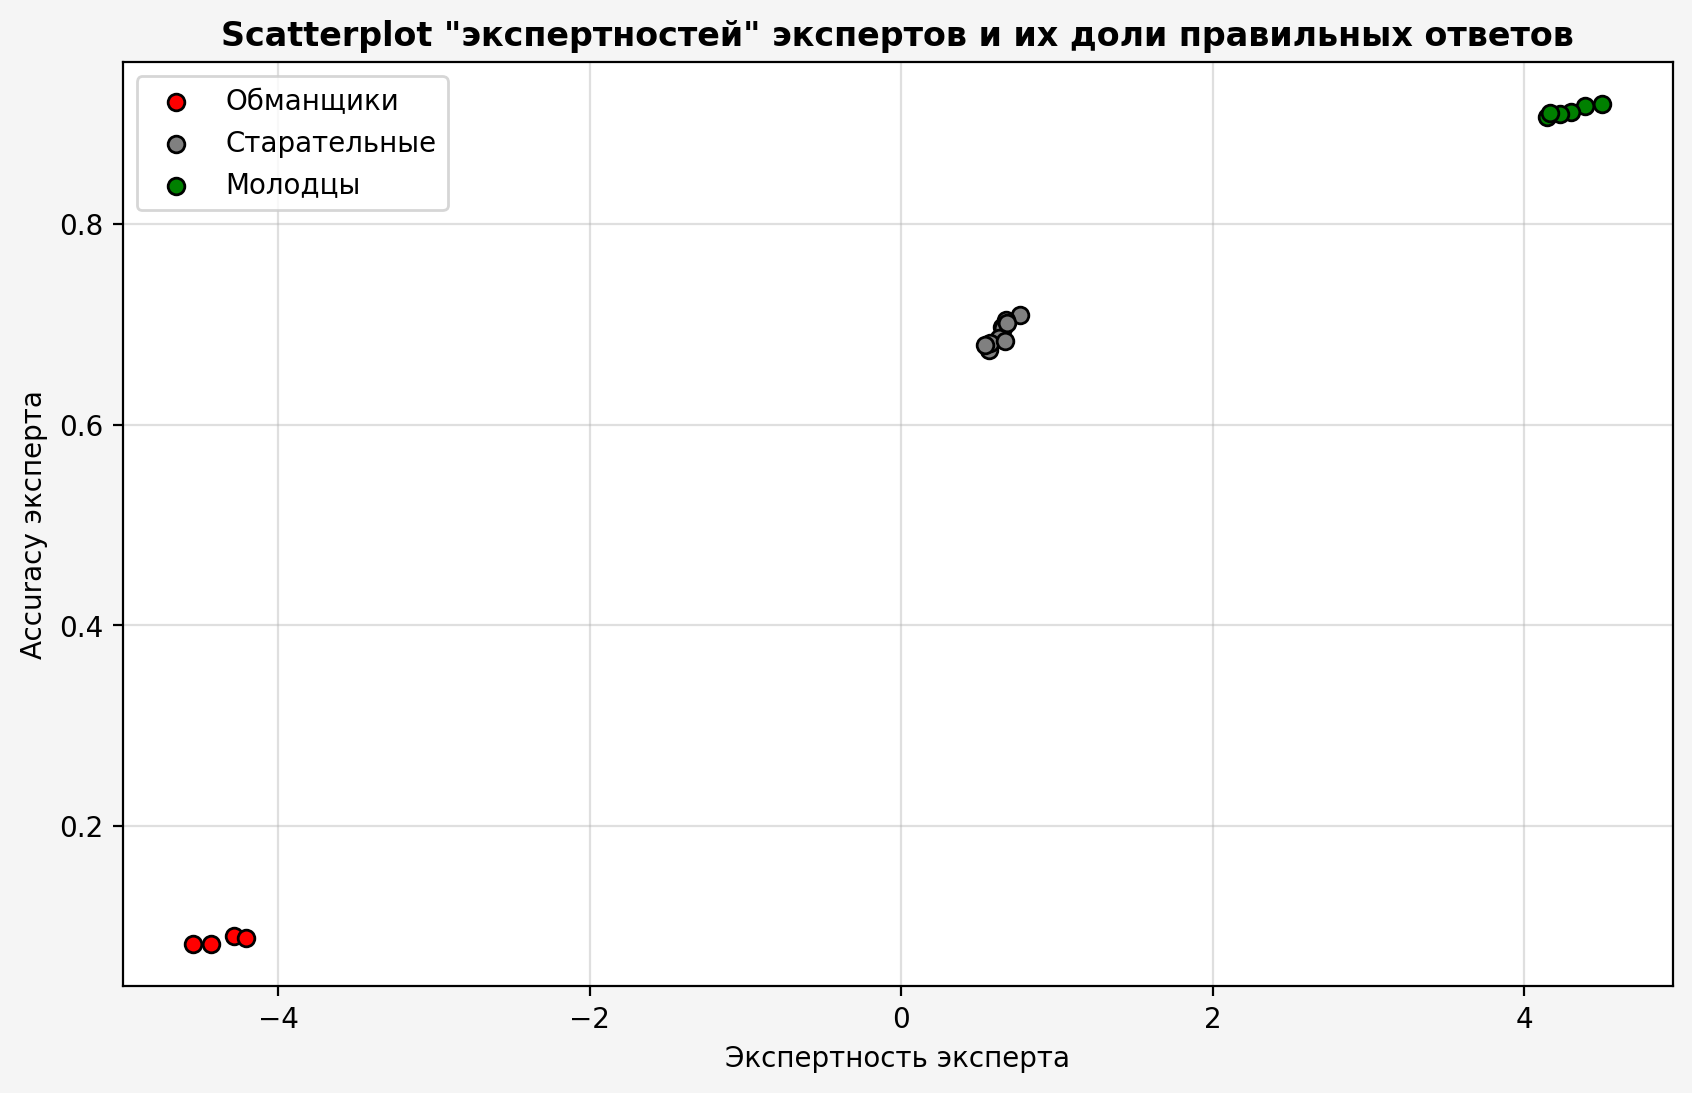

In [13]:
fig = plt.figure(figsize=(10, 6), facecolor='whitesmoke')

plt.scatter(alpha[alpha <= -2], exp_accuracies[alpha <= -2], color='red', edgecolor='black', label='Обманщики')
plt.scatter(alpha[(alpha <= 2) & (alpha >= -2)], exp_accuracies[(alpha <= 2) & (alpha >= -2)], color='grey', edgecolor='black', label='Старательные')
plt.scatter(alpha[2 <= alpha], exp_accuracies[2 <= alpha], color='green', edgecolor='black', label='Молодцы')

plt.title('Scatterplot "экспертностей" экспертов и их доли правильных ответов', weight = 'bold')
plt.xlabel('Экспертность эксперта')
plt.ylabel('Accuracy эксперта')

plt.legend()
plt.grid(alpha=0.4)
plt.show()

Зелёным я отметил хороших чуваков (зелёный=хорошо), серым - старательных чуваков, у которых не всегда получается правильно разметить картинку (либо им в какой-то момент становится пофик и они размечают рандомно), а красным - обманщиков, которые знают правильные ответы, но отмечают неправильные. Посмотрим, сколько чуваков в каждой категории:

In [ ]:
print(f'Обманщиков {(alpha <= -2).sum()}')
print(f'Старательных но бездарных {((alpha <= 2) & (alpha >= -2)).sum()}')
print(f'Классных челов {(2 <= alpha).sum()}')

Обманщиков 6
Старательных но бездарных 10
Классных челов 4


Видим по графику, что есть 4 обманщика, которые специально неверно размечают выборку, хотя знают правильный ответ.

## **Задание 4. (бонус, 2 балла)**  
Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

По сути, нам достаточно заменить некоторые столбики (пары $(q_0, q_1)$) на пару $(0, 1)$ либо $(1, 0)$. Для этого я всего лишь слегка поменяю свой предыдущий класс. Ну и подсчёт accuracy тоже подкорректирую, чтобы мы accuracy предиктили по тем задачкам, для которых ответов не знаем.

In [ ]:
class EM_Algorithm:
    def __init__(self, L:np.ndarray, lr: float=1e-3, n_steps: int=1000, know_answers=False, answers=None, n_answers=None):
        self.L = L #(n_problems, n_experts)
        self.n_problems, self.n_experts = L.shape
        self.lr = lr
        self.n_steps = n_steps
        self.alpha = np.random.randn(self.n_experts) #(n_experts, )
        self.logbeta = np.random.randn(self.n_problems)#(n_problems, )
        self.beta = np.exp(self.logbeta)
        self.q = np.ones((2, self.n_problems)) * 0.5
        self.know_answers = know_answers
        if self.know_answers:
            self.known_indices = np.random.choice(np.arange(self.n_problems), size=n_answers, replace=False) #генерим индексы вопросов с известными ответами
            self.unknown_indices = np.setdiff1d(np.arange(self.n_problems), self.known_indices) #хз как сделать это проще
            self.answers = answers

        # ниже общие переменные, которые будут пересчитываться лишь раз за итерацию алгоритма
        # (в предложенной шаблоном структуре эти переменные пересчитывались бы несколько раз)
        self.outer = None
        self.S_pos = None
        self.S_neg = None
        self.M_0 = None
        self.M_1 = None

    def update_commons(self):
        """
        Updates common model parameters while fitting
        """
        self.outer = np.outer(self.beta, self.alpha)
        self.S_pos = sigmoid(self.outer)
        self.S_neg = sigmoid(-self.outer)
        self.M_0 = self.S_neg * (1 - self.L) - self.S_pos * self.L
        self.M_1 = self.S_neg * self.L - self.S_pos * (1 - self.L)

    def calc_gamma(self):
        """ Stable auxilary function for calculating posterior. 
        Uses -sofplus(-...) instead of log(sigmoid(...))
        Args:
            alpha: ndarray of shape (n_experts).
            beta: ndarray of shape (n_problems).
            L: binary ndarray of shape (n_problems, n_experts).
        Returns: gamma for future transformation to q = softmax(gamma): ndarray of shape (2, n_problems)
        """
        pos, neg = softplus(self.outer), softplus(-self.outer) # (n_problems, n_experts)

        gamma_0 = np.log(0.5) + np.sum((1-L) * (-neg) + L*(-pos), axis=1)
        gamma_1 = np.log(0.5) + np.sum(L * (-neg) + (1-L) * (-pos), axis=1)

        return np.vstack((gamma_0, gamma_1))

    def posterior(self):
        """ Posterior over true labels z p(z = 1|l, alpha, beta)
        Args:
            alpha: ndarray of shape (n_experts).
            beta: ndarray of shape (n_problems).
            L: ndarray of shape (n_problems, n_experts).
        Returns: q - posterior distribution of z: ndarray of shape (2, n_problems)
        """
        gamma = self.calc_gamma()
        q = softmax(gamma, axis=0)
        if self.know_answers: #только в случае, если ответы нам известны
            q[0, self.known_indices] = 1 - self.answers[self.known_indices]
            q[1, self.known_indices] = self.answers[self.known_indices]
        return q

    def calc_grad(self):
        """Calculates both gradients simultaneously.
        Note that dl/dlog(b) = dl/db * b
        Returns: gradient of E(log-likelihood) wrt to alpha and log(beta)
        """
        grad_alpha = np.dot(self.M_0.T, self.q[0] * self.beta) + np.dot(self.M_1.T, self.q[1] * self.beta)
        grad_logbeta = (np.dot(self.M_0, self.alpha) * self.q[0] + np.dot(self.M_1, self.alpha) * self.q[1]) * self.beta
        return grad_alpha, grad_logbeta

    def alpha_grad_lb(self):
        return np.dot(self.M_0.T, (self.q[0] * self.beta)) + np.dot(self.M_1.T, (self.q[1] * self.beta))
    
    def logbeta_grad_lb(self):
        return (np.dot(self.M_0, self.alpha) * self.q[0] + np.dot(self.M_1, self.alpha) * self.q[1]) * self.beta

    def fit(self):
        for _ in range(self.n_steps):
            self.update_commons()
            self.q = self.posterior()

            grad_alpha, grad_logbeta = self.calc_grad()
            self.alpha += self.lr * grad_alpha
            self.logbeta += self.lr * grad_logbeta

            self.beta = np.exp(self.logbeta)
            
        return self.alpha, np.exp(self.logbeta), self.q
    
    def accuracy(self, y_true):
        if self.know_answers: #если ответы известны, то accuracy на них не считаем
            if accuracy_score(y_true, np.argmax(self.q, axis=0)) >= 0.5:
                return accuracy_score(y_true[self.unknown_indices], np.argmax(self.q[:, self.unknown_indices], axis=0))
            else:
                return accuracy_score(y_true[self.unknown_indices], np.argmin(self.q[:, self.unknown_indices], axis=0))
        
        else:
            if accuracy_score(y_true, np.argmax(self.q, axis=0)) >= 0.5:
                return accuracy_score(y_true, np.argmax(self.q, axis=0))
            else:
                return accuracy_score(y_true, np.argmin(self.q, axis=0))

In [ ]:
model = EM_Algorithm(L, lr=1e-3, n_steps=1000, know_answers=True, answers=y, n_answers=10)

alpha, beta, q = model.fit()

model.accuracy(y)

0.9552763819095478

Если мы даём известную разметку для 10 объектов, то accuracy алгоритма растёт совсем чуть-чуть, но всё же растёт. 

Теперь сделаем так: для каждого значения n_answers в промежутке `n_low`, `n_high` прогоним `n_attemts` моделей нашего ЕМ алгоритма и посмотрим, как он accuracy меняется в зависимости от n_answers.

In [ ]:
#заполняем стату по средней accuracy и её std
n_low, n_high, n_attempts = 10, 500, 10
n_answers_range = np.arange(n_low, n_high, 50)

em_stats = {
    'accuracy_mean': [],
    'accuracy_std': []
}

for n_answers in n_answers_range:
    accuracies = []
    stds = []

    for _ in range(n_attempts):
        model = EM_Algorithm(L, lr=1e-3, n_steps=1000, know_answers=True, answers=y, n_answers=n_answers)
        model.fit()
        accuracies.append(model.accuracy(y))

    em_stats['accuracy_mean'].append(np.mean(accuracies))
    em_stats['accuracy_std'].append(np.std(accuracies))

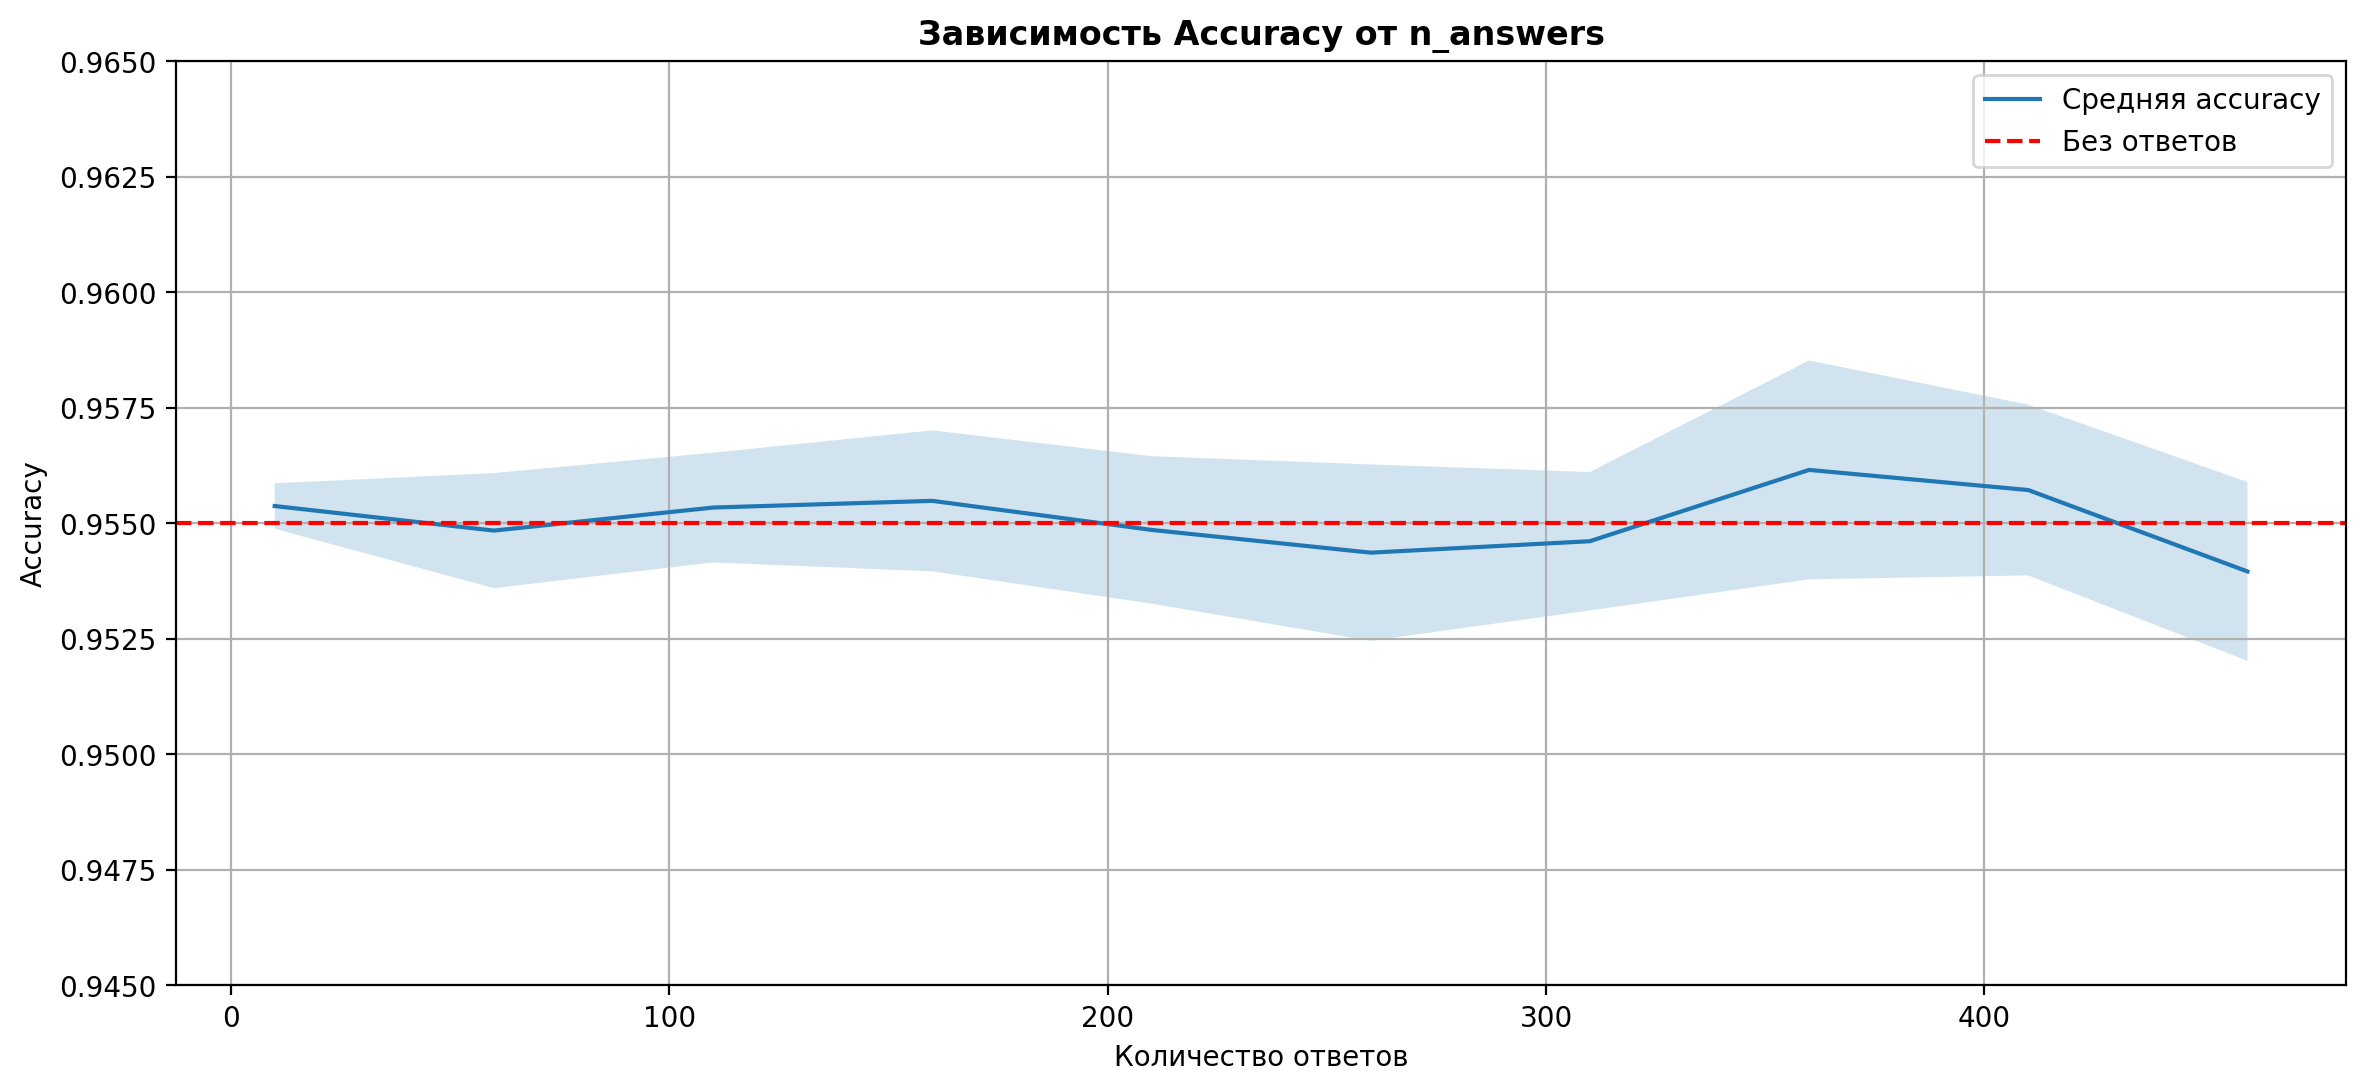

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(n_answers_range, em_stats['accuracy_mean'], label='Средняя accuracy')
ax.fill_between(n_answers_range, np.subtract(em_stats['accuracy_mean'], em_stats['accuracy_std']), np.add(em_stats['accuracy_mean'], em_stats['accuracy_std']), alpha=0.2)

ax.set_title('Зависимость Accuracy от n_answers', weight='bold')
ax.set_xlabel('Количество ответов')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.945, 0.965)
ax.grid(True)

plt.axhline(y=0.955, linestyle='--', label='Без ответов', color='red')
ax.legend()

plt.show()

Ничего сверхчудесного не наблюдаем. Что с ответами - что без. Другое дело, что в такой ситуации мы точно не перепутаем обманщиков с трушными чуваками, как иногда могло случаться в предыдущей версии алгоритма (и это иногда происходило!)

# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [2]:
%%bash
# wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


## **Задание -2. (0.5 балла)** 
Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

[Ссылка](https://contest.yandex.ru/contest/60281/run-report/110569569/) на посылку в контесте.

In [32]:
all_sentences = []
all_targets = []

for filename in glob.glob('data/*/*/*.wa'):
    sentences, alignments = extract_sentences(filename)
    all_sentences.extend(sentences)
    all_targets.extend(alignments)

## **Задание -1. (0.5 балла)** 
Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

[Ссылка](https://contest.yandex.ru/contest/60281/run-report/110822422/) на посылку в контесте.

In [4]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [5]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

## **Задание 0. (0.5 балла)** 
Реализуйте функции `compute_precision`, `compute_recall`, `compute_aer` из модуля `metrics.py`. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

[Ссылка](https://contest.yandex.ru/contest/60281/run-report/110570385/) на посылку в контесте

In [6]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8115275584918071

## **Задание 1. (2 балла)** 
Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

### **Решение**

В [статье](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1162/handouts/Collins_annotated.pdf) наши параметры $\theta(t_i|s_{a_i})$ называются $t(t_{i}|s_{a_i})$ - translation probabilities, а псевдонимом для $\frac{1}{l_k}$ служит $q(j|i, l, m)$ - alignment probabilities. У нас $\theta(t|s)$ - условная вероятность того, что слово $t \in \mathcal{T}$ будет сгенерировано из слова $s \in \mathcal{S}$. Эти параметры $\theta$ мы и хотим оценить. При этом для них, конечно, должно выполняться свойство 
$$
\sum_{t\in \mathcal{T}}\theta(t|s) = 1
$$ 
для любого $s \in S$.

Аналогично статье, положим $n$ - размер тренировочного корпуса, $k= \overline{1, n}$ - номер предложения из тренировочного корпуса, $l_k \in \{1,\ldots, L\}$ - длина source предложения, $m_k \in \{1,\ldots, M \}$ - длина target предложения. 

### **Е-шаг**
Тогда на **$E$-шаге** нашей модели мы выводим апостериорное распределение скрытых переменных $A$ (выравниваний):
$$
P(A_i=j|\ s_1,\ldots,s_{l_k}, t_1, \ldots, t_{m_k}, m_k) =:
 \delta(k, i, j) = 
 \dfrac
 {\frac{1}{m_k}\theta(t_{i}^{(k)} | s_j^{(k)})}
 {\sum_{j=1}^{l_k}\frac{1}{m_k}\theta(t_{i}^{(k)} | s_j^{(k)})} = 
 \dfrac
 {\theta(t_{i}^{(k)} | s_j^{(k)})}
 {\sum_{j=1}^{l_k}\theta(t_{i}^{(k)} | s_j^{(k)})}
$$
Полученное выражение - это вероятность того, что скрытая переменная $a_i$ примет значение $j$ при текущих известных параметрах $\theta$ в $k$-й паре предложений.

### **M-шаг**

На **$M$-шаге** мы максимизируем матожидание лог-правдоподобия, которое берётся по скрытым переменным:

$$
    \mathbb{E}_{A \sim P(A|T,\ S,\ \theta^{\text{old}})}
    \left[
        \log p(A, T| S, \theta)
    \right] = 
    \sum_{k, i, j} \delta(k, i, j) \times 
    \log
    \left(
        \dfrac{\theta(t_i^{(k)}|s_{a_{i}^{(k)}}^{(k)})}{\delta(k,i,j) \times l_k}
    \right) \rightarrow \max_{\theta}
$$
При этом надо понимать, что под тройным индексом у суммы скрывается по-настоящему адское выражение:

$$\log \mathcal{L} = 
\sum_{k=1}^n 
\sum_{j=1}^{l_k}
\sum_{i=1}^{m_k} 
\left[
    \delta(k, i, j) \times 
    \log
    \left(
        \dfrac{\theta(t_i^{(k)}|s_{a_{i}^{(k)}}^{(k)})}{\delta(k,i,j) \times l_k}
    \right)
\right] \propto 
\sum_{k=1}^n 
\sum_{j=1}^{l_k}
\sum_{i=1}^{m_k} 
\left[
    \delta(k, i, j) \times 
    \log
    \left(
        \theta(t_i^{(k)}|s_{a_{i}^{(k)}}^{(k)})
    \right)
\right] 
\rightarrow \max_{\theta}
$$

Индексы означают следующее: 
- $k$-номер пары предложений $(s^{(k)}, t^{(k)})$ в корпусе, 
- $i$ - номер слова в $t^{(k)}$,
- $j$ - номер слова в $s^{(k)}$.

Отметим также, что наш вектор параметров $\theta$ - это и не вектор вовсе, а матрица размера $|\mathcal{S}| \times |\mathcal{T}|$. Поскольку на каждую строчку этой матрицы накладываются ограничения 
$
\sum_{t\in \mathcal{T}}\theta(t|s) = 1
$, то это задача условной максимизации, для которой мы запишем лагранжиан:
$$
L = 
\sum_{k=1}^n 
\sum_{j=1}^{l_k}
\sum_{i=1}^{m_k} 
\left[
    \delta(k, i, j) \times 
    \log
    \left(
        \theta(t_i^{(k)}|s_{a_{i}^{(k)}}^{(k)})
    \right)
\right] + 
\sum_{s\in S} \lambda_s (1- \sum_{t \in \mathcal{T}}\theta(t|s))
$$

Возьмём производную лагранжиана по произвольному параметру $\theta(t|s)$:

$$
\dfrac
{\partial L}
{\partial \theta(t|s)} = 
\sum_{k=1}^n 
\sum_{j=1}^{l_k}
\sum_{i=1}^{m_k} 
\left[
    \delta(k, i, j) \times 
    \dfrac
    {1}
    {\theta(t|s)} \times
    \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s) \times
    \mathbb{I}(t_i^{(k)} = t)
\right] - \lambda_s
$$
Вынося за знаки суммирования $\theta(t|s)$ и приравнивая к нулю частную производную, получаем:
$$
\theta^*(t|s) = 
\dfrac{
    \sum_{k=1}^n 
    \sum_{j=1}^{l_k}
    \sum_{i=1}^{m_k} 
    \left[
        \delta(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s) \times
        \mathbb{I}(t_i^{(k)} = t)
    \right]
}
{\lambda_s}
$$

Тогда становится понятно, что $\lambda_s$ будет нормировочной константой, и знаменатель просто окажется суммой всех числителей:
$$
\theta^*(t|s) = 
\dfrac{
    \sum_{k=1}^n 
    \sum_{j=1}^{l_k}
    \sum_{i=1}^{m_k} 
    \left[
        \delta(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s) \times
        \mathbb{I}(t_i^{(k)} = t)
    \right]
}
{
    \sum_{t\in \mathcal{T}}
    \sum_{k=1}^n 
    \sum_{j=1}^{l_k}
    \sum_{i=1}^{m_k} 
    \left[
        \delta(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s) \times
        \mathbb{I}(t_i^{(k)} = t)
    \right]
}=
\dfrac{
    \sum_{k=1}^n 
    \sum_{j=1}^{l_k}
    \sum_{i=1}^{m_k} 
    \left[
        \delta(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s) \times
        \mathbb{I}(t_i^{(k)} = t)
    \right]
}
{
    \sum_{k=1}^n 
    \sum_{j=1}^{l_k}
    \sum_{i=1}^{m_k} 
    \left[
        \delta(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s)
    \right]
}
$$

Примечание: через $\mathbb{I}(X)$ обозначен индикатор условия $X$.

## **Задание 2. (2.5 балла)** 
Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

[Ссылка](https://contest.yandex.ru/contest/60281/run-report/110824562/) на посылку в контесте.

In [6]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 5)
word_aligner.fit(tokenized_sentences);

compute_aer(all_targets,word_aligner.align(tokenized_sentences))

0.589783111306837

Супер! Качество сильно лучше бейзлайна. На 5 эпохах имеем 0.589

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [13]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

def translate_source(word: str, top_n=3):
    """Переводим слова с английского на чешский

    Args:
        word (str): слово на английском
        aligner (_type_, optional): _description_. Defaults to word_aligner.
        top_n (int): сколько наиболее вероятных слов выводить

    Returns:
        (str): перевод на чешский язык нашего слова (top_n наиболее вероятных переводов)
    """
    return [idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src[word]].argsort()[-top_n:]][::-1]

In [14]:
translate_source('Mr')

['pan', 'řekl', 'Pan']

In [15]:
translate_source('Mrs')

['paní', 'Mannová', '-']

In [16]:
translate_source('water')

['vody', 'pro', 'z']

In [17]:
translate_source('depended')

['jež', 'konec', 'dne']

In [18]:
translate_source('on')

['na', 'se', '.']

## **Задание 3. (0.5 балла)** 
Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

Не сразу понял, что вщ просят) Да, теперь мы можем переводить не только английский в чешский, но и чешский в английский. У нас теперь есть $\theta(t | s)$ - вероятность того, что слово $s\in \mathcal{S}$ перевеодится как $t \in \mathcal{T}$. 

Значит можем получить $\theta(s|t) = \dfrac{\theta(t|s) \theta(s)}{\theta(t)}$, где по сути $\theta(x)$ - частота слова $x$ во всём корпусе.

In [19]:
#подсчитаем частоту для каждого слова из source и из target, мы уже это делали в preprocessing-е
from collections import Counter

src_freq_counter = Counter()
tgt_freq_counter = Counter()

for sentence_pair in all_sentences:
    src_freq_counter.update(sentence_pair.source) 
    tgt_freq_counter.update(sentence_pair.target)

#делаю массивчики, чтобы потом получить матрицу вероятностей переводов из чешского в англ
src_freqs = np.zeros(len(t_idx_src))
tgt_freqs = np.zeros(len(t_idx_tgt))

#заполняю массивчики
for word, index in t_idx_src.items():
    src_freqs[index] = src_freq_counter.get(word, 0)

for word, index in t_idx_tgt.items():
    tgt_freqs[index] = tgt_freq_counter.get(word, 0)

#делю, чтобы были именно частоты
src_freqs /= np.sum(src_freqs)
tgt_freqs /= np.sum(tgt_freqs)

#делаем словарик аналогично чешскому и составляем матрицу аналогичных вероятностеф
idx_token_src = {index:token for token, index in t_idx_src.items()}
inverse_translation_probs = (word_aligner.translation_probs * src_freqs.reshape(-1, 1) / tgt_freqs.reshape(1, -1))

In [20]:
def translate_target(word: str, top_n=3):
    """Переводим чешские слова в английские

    Args:
        word (str): слово на чешском языке (target language)
        aligner (BaseAligner): выравниватель 
        top_n (int):
    
    Returns:
        top_n наиболее вероятных переводов
    """
    #здесь достаточно просто транспонировать матричку
    return [idx_token_src[i] for i in inverse_translation_probs.T[t_idx_tgt[word]].argsort()[-top_n:]][::-1]

Продемонстрируем работу нашей функции на чешских словах:

In [21]:
translate_target('imperátor')

['colossus', 'bestrode', 'dollar']

In [22]:
translate_target('mořské')

['seawater', 'burns', 'infinite']

In [23]:
translate_target('pět')

['five', 'behind', 'lags']

In [24]:
translate_target('velký')

['huge', 'factor', "'d"]

Всё чудесно работает!

## **Задание 4. (0.5 балла)** 
Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

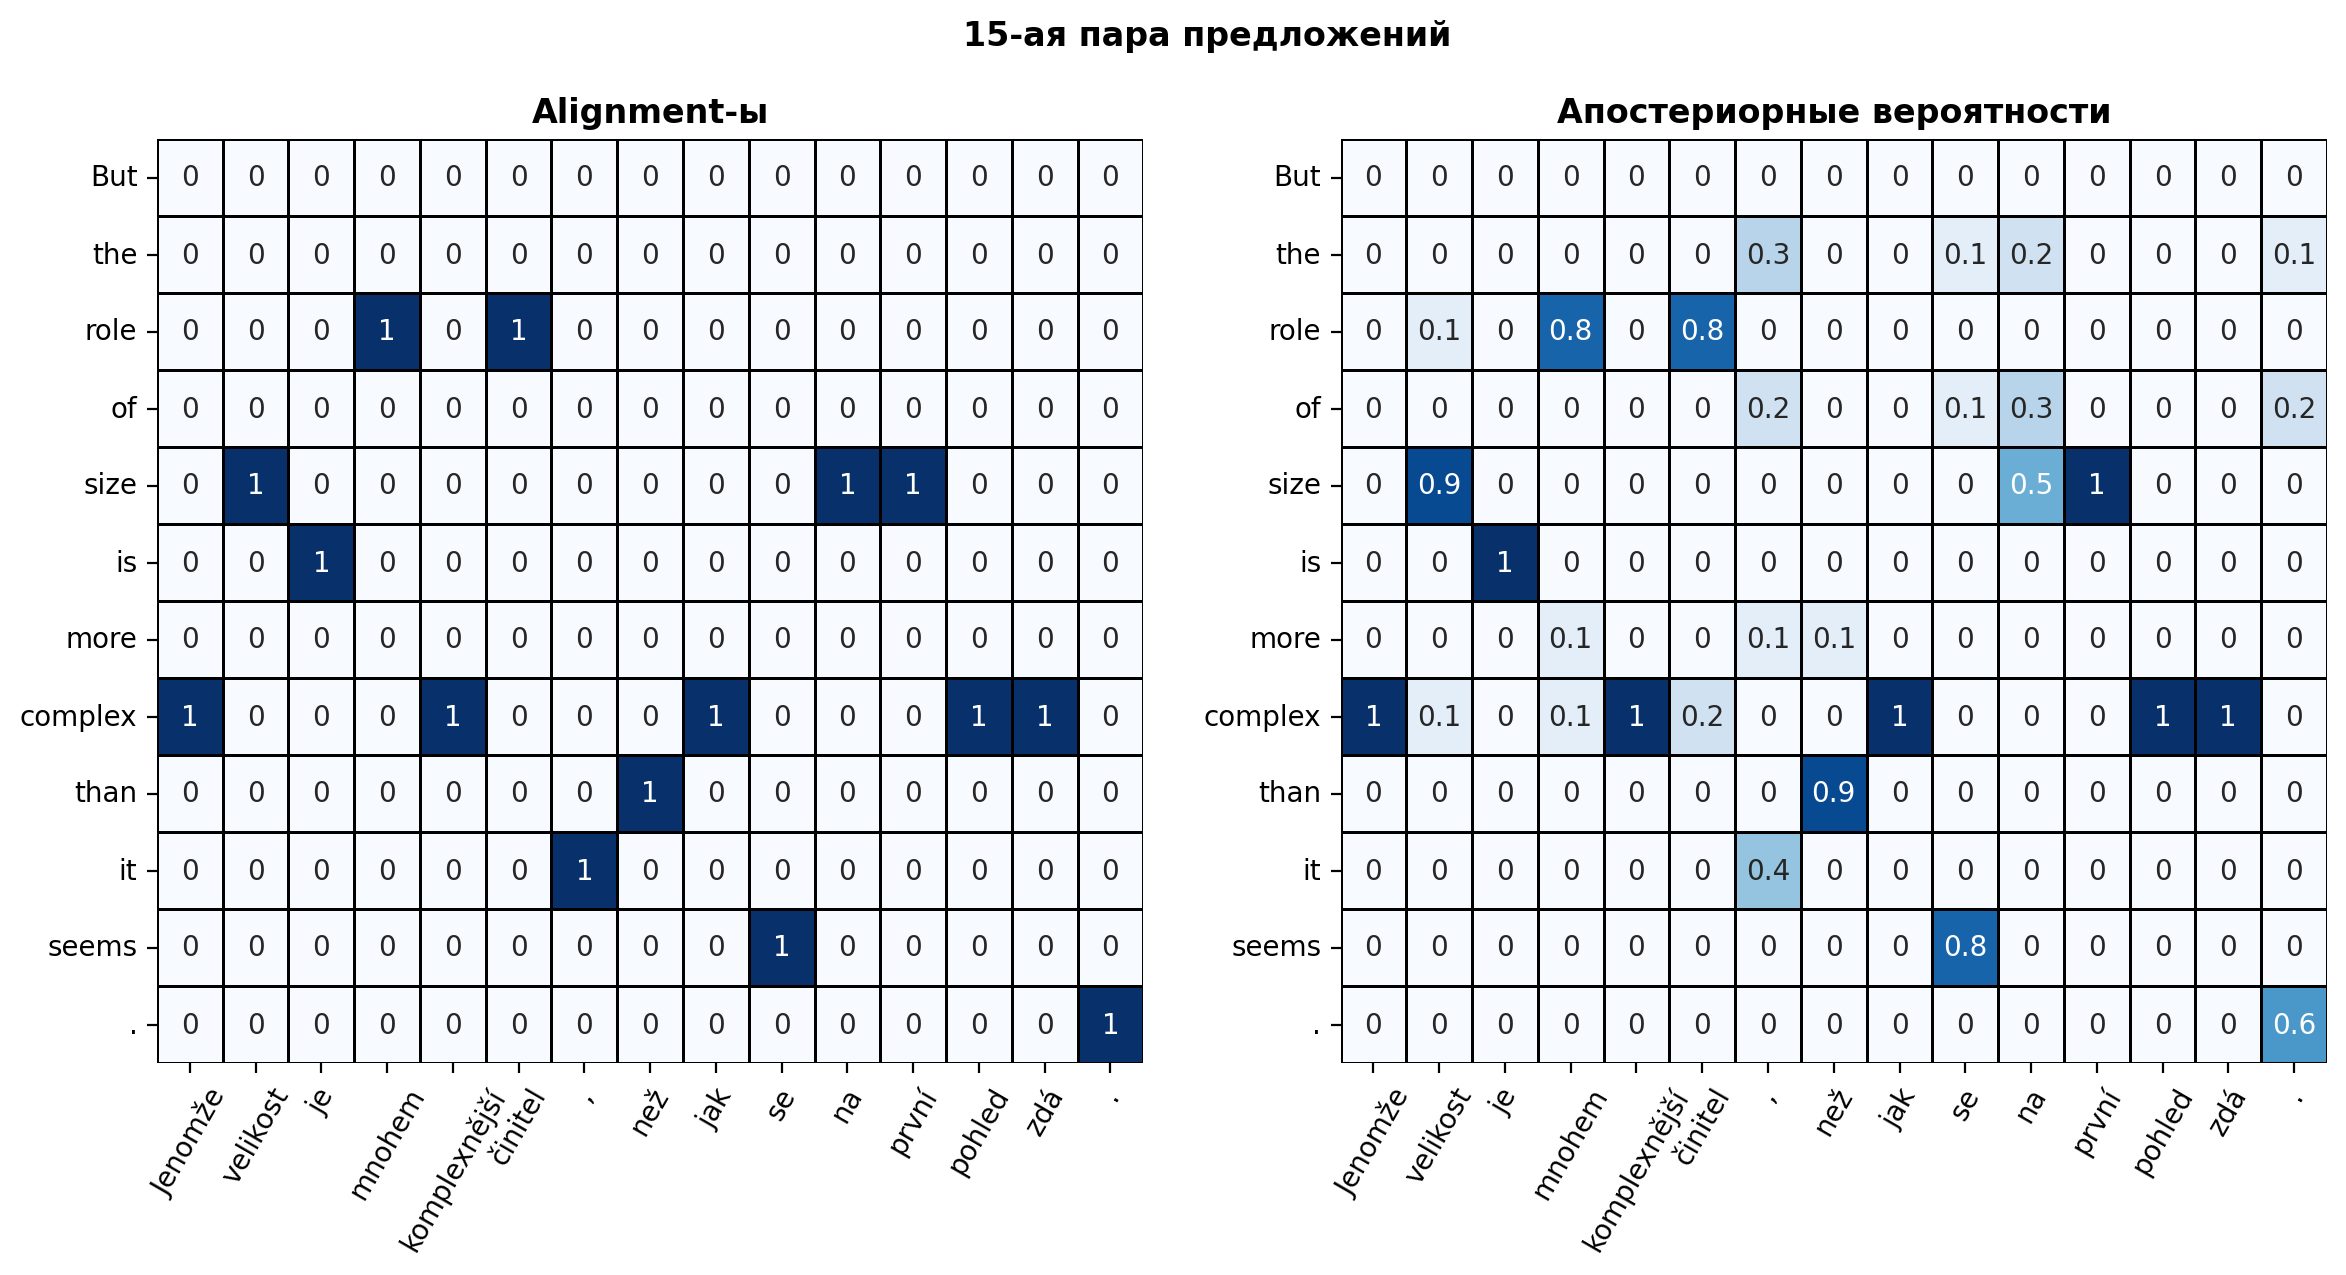

In [25]:
from preprocessing import SentencePair, tokenize_sents
from models import get_indices, BaseAligner
from typing import Tuple

#сама функция для отрисовки, апостериорные вероятности округляем до первого знака после запятой
def sentence_heatmap(pair_num: SentencePair, aligner: BaseAligner, figsize: Tuple[int, int]=(14, 6)):
    pair = all_sentences[pair_num]
    h, w = len(pair.source), len(pair.target)
    tokenized_pair = tokenize_sents([pair], t_idx_src, t_idx_tgt)

    discrete_matrix = np.zeros((h, w))
    for src_idx, tgt_idx in aligner.align(tokenized_pair)[0]:
        discrete_matrix[src_idx-1, tgt_idx-1] = 1

    full_matrix = aligner.translation_probs[get_indices(tokenized_pair[0])] / np.sum(aligner.translation_probs[get_indices(tokenized_pair[0])], axis=0)

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.heatmap(discrete_matrix, ax=ax[0], cmap='Blues', annot=True, linewidths=.5, cbar=False, xticklabels=pair.target, yticklabels=pair.source, linecolor='black')
    sns.heatmap(np.round(full_matrix, 1), ax=ax[1], cmap='Blues', annot=True, linewidths=.5, cbar=False, xticklabels=pair.target, yticklabels=pair.source, linecolor='black')

    ax[0].set_title(f'Alignment-ы', weight='bold')
    ax[1].set_title(f'Апостериорные вероятности', weight='bold')

    plt.suptitle(f'{pair_num}-ая пара предложений', weight='bold')
    
    for i in range(2):
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=60)
        # ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=30)
    plt.show()


#тестим график
sentence_heatmap(15, word_aligner)

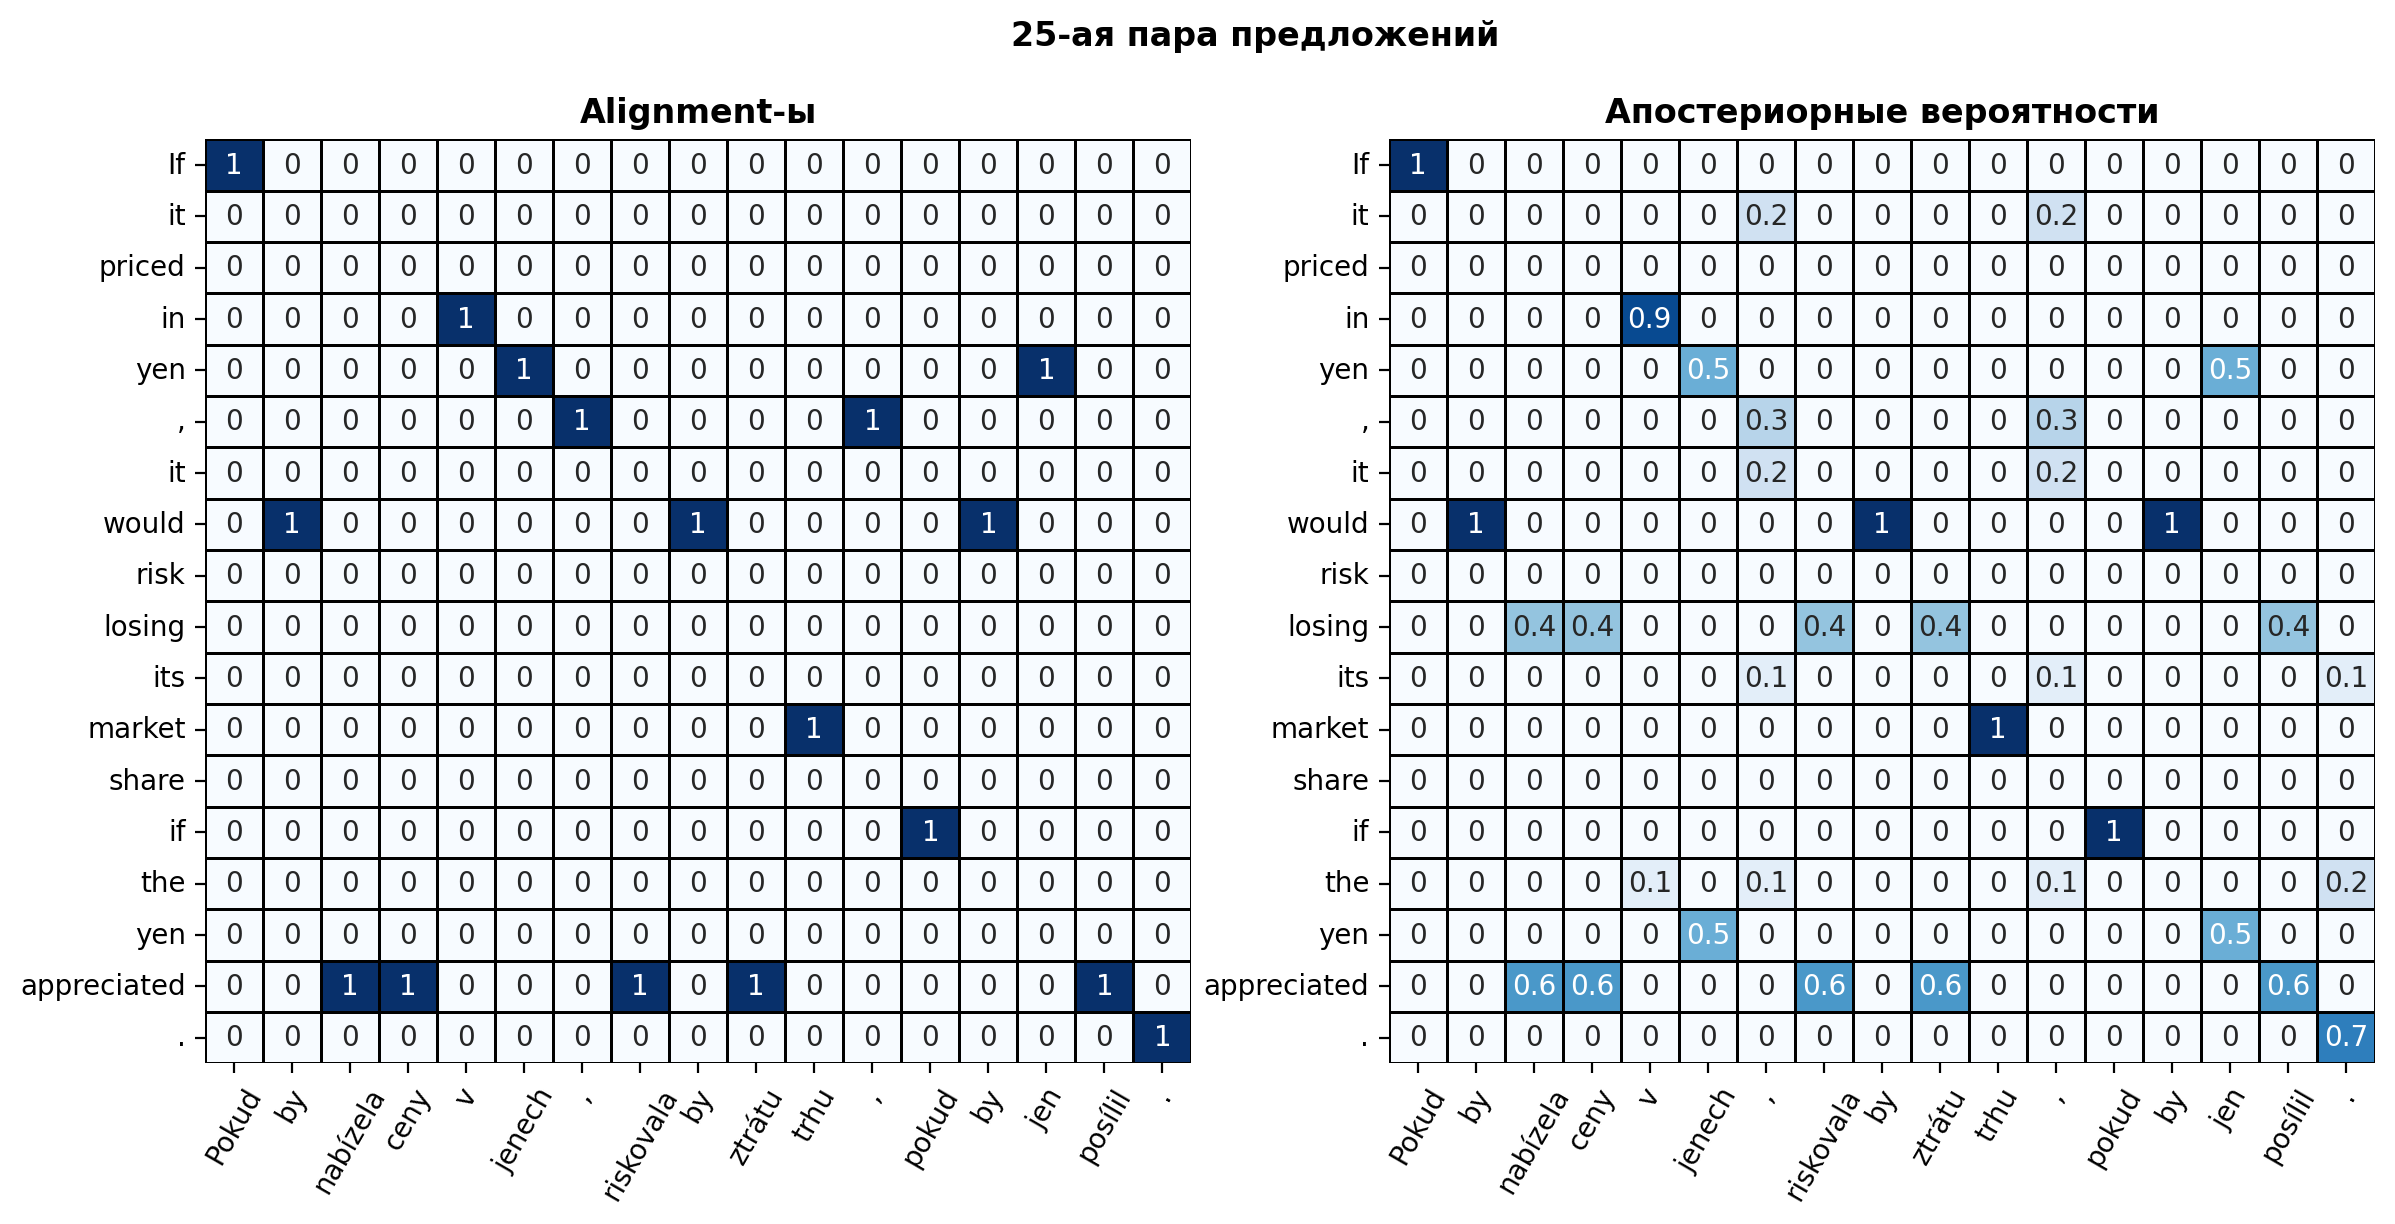

In [26]:
sentence_heatmap(25, word_aligner)

На графике выше бросается в глаза, что часто мэтчатся слова, занимающие в предложении одинаковые места по порядку (такие пары слов находятся на диагонали). 

Ситуации, когда aligner не уверен, тоже встречаются (когда в одном столбике встречаются клетки с вероятностями примерно 0.5). Например, в 25-й паре предложений моделька не уверена, что соответствует словам 'jenech', 'by', 'ceny'.

## **Задание 5. (1.5 балла)** 
Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$
Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

**Решение**

Теперь в дело вступают $q(j|i, l, m)$ - alignment probabilities, которые в этом задании замаскированы как $\phi_{l,m}(j|i)$, а в прошлом пункте они назывались $\dfrac{1}{l_k}$ и были константами, а не настроиваемыми параметрами. До этого у нас было только пространство параметров для переводов
 $$\Theta = 
 \{\theta :\  \forall s, t: \ \theta(t|s) \geq 0,\ \forall  s \in \mathcal{S}:\ \sum_{t\in \mathcal{T}}\theta(t|s) = 1 \}$$

Теперь у нему добавляется пространство параметров для выравниваний:
$$\mathcal{Q} = \{q:\ \forall j,i,l,m \ q(j|i,l,m) \geq 0, \ \forall \ i, l, m \sum_{j = 0}^{l}q(j|i, l, m) = 1 \}$$

Я буду использовать $q(j| i, l, m)$ вместо $\phi_{l,m}(j|i)$, поскольку на листке выводил в таких обозначениях (и они же приняты в статье). Аналогично предыдущему пункту, положим $n$ - размер тренировочного корпуса, $k= \overline{1, n}$ - номер предложения (пары предложений) из тренировочного корпуса, $l_k \in \{1,\ldots, L\}$ - длина source предложения, $m_k \in \{1,\ldots, M \}$ - длина target предложения. 

**Е-шаг**

На Е-шаге мы так же считаем $\delta(k, i, j)$, которые теперь принимают более сложный вид, в соответствии с нашей моделью:

$$
\delta(k, i, j) =
\dfrac
{
    q(j| i, l, m) \times \theta(t_i^{(k)} | s_i^{(k)})
}
{
    \sum_{j=0}^{l_k} q(j| i, l, m) \times \theta(t_i^{(k)} | s_i^{(k)})
}
$$

**М-шаг**

Выпишем теперь матож лог-правдоподобия (формула такая же, как и в прошлом пункте, только вместо $\dfrac{1}{l_k}$ теперь $q(j|i, l, m)$):

$$\log \mathcal{L} = 
\sum_{k=1}^n 
\sum_{j=1}^{l_k}
\sum_{i=1}^{m_k} 
\left[
    \delta^{\text{OLD}}(k, i, j) \times 
    \log
    \left(
        \dfrac{\theta(t_i^{(k)}|s_{j}^{(k)}) \times q(j|i, l, m)}{\delta^{\text{OLD}}(k,i,j)}
    \right)
\right] \propto 
\sum_{k=1}^n 
\sum_{j=1}^{l_k}
\sum_{i=1}^{m_k} 
\left[
    \delta^{\text{OLD}}(k, i, j) \times 
    \log
    \left(
        \theta(t_i^{(k)}|s_{j}^{(k)}) \times q(j|i, l, m)
    \right)
\right] 
\rightarrow \max_{\theta, q}
$$

Тут я подчёркиваю, что веса, с которыми суммируются лог-правдоподобия - это именно параметры с предыдущего шага (OLD), поэтому по ним производную брать будет не нужно. Теперь видим, что можем разложить логарифм произведения в сумму логарифмов:
$$
\sum_{k, j, i}
\left[
    \delta^{\text{OLD}}(k, i, j) \times 
    \log
    \left(
        \theta(t_i^{(k)}|s_{j}^{(k)} \times q(j|i, l, m))
    \right)
\right] 
 = 
\sum_{k, j, i}
\left[
    \delta^{\text{OLD}}(k, i, j) \times 
    \log
    \left(
        \theta(t_i^{(k)}|s_{j}^{(k)})
    \right)
\right] 
+
\sum_{k, j, i}
\left[
    \delta^{\text{OLD}}(k, i, j) \times 
    \log
    \left(
        q(j|i,l,m)
    \right)
\right] 

$$

Получаем, что можно максить наше ELBO отдельно по $\theta$ и отдельно по $q$ (которое в условии называется $\phi$)! Отлично, потому что для $\theta$ мы уже вывели формулу:

$$
\theta^{*}(t|s) = 
\dfrac{
    \sum_{k, j, i}
    \left[
        \delta^{\text{OLD}}(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s) \times
        \mathbb{I}(t_i^{(k)} = t)
    \right]
}
{
    \sum_{k, j, i}
    \left[
        \delta^{\text{OLD}}(k, i, j) \times
        \mathbb{I}(s_{a_{i}^{(k)}}^{(k)} = s)
    \right]
}
$$

А для $q$ всё аналогично, поскольку это точно такая же взвешенная сумма логарифмов, которую мы максим с ограничениями. Записываем лагранжиан и дифференцируем его
$$
L = \sum_{k, j, i}
\left[
    \delta^{\text{OLD}}(k, i, j) \times 
    \log
    \left(
        q(j|i,l,m)
    \right)
\right] + \sum_{k, i} 
\left[
    \lambda_i^{(k)} \times (1 - \sum_{j = 0}^{l_k}q(j|i, l, m))
\right]
$$

Дифференцируем по произвольному $q(y|u, v, w)$ и приравниваем производную к нулю:
$$
\dfrac{\partial L}{\partial q(y|u, v, w)} = \sum_{k, j, i}
\left[
    \dfrac
    {
        \delta^{\text{OLD}}(k, i, j)
    }
    {
        q(y |u, v, w)
    } \times \mathbb{I}(j = y,\ i=u,\ v=l,\ w=m)
\right] 
-
\sum_{k, i} \lambda_i^{(k)} 
\times 
\mathbb{I}(j = y,\ i=u,\ v=l,\ w=m)
$$
Теперь нормировочную роль играет $\sum_{k, i} \lambda_i^{(k)}  \times \mathbb{I}(j = y,\ i=u,\ v=l,\ w=m)$, но ничего страшного, производную мы всё равно приравниваем к нулю и получаем выражение, аналогичное полученному в тексте, посвященном IBM моделям 1 и 2 (статья, ссылку на которую я оставлял в предыдущем выводе). В случае бинарных $\delta(k, i, j)$ у нас получались бы очень удобные оценки (см страницу 11). У нас же получается всё менее приятно:
$$
q^*(y|u,v,w) = 
\dfrac
{
    \sum_{k, j, i} \delta^{\text{OLD}}(k, i, j) \times \mathbb{I}(j = y,\ i=u,\ v=l,\ w=m)
}
{
    \sum_{k, j, i} \delta^{\text{OLD}}(k, i, j) \times \mathbb{I}(i=u,\ v=l,\ w=m)
}
$$

## **Задание 6. (2 балла)** 
Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

[Ссылка](https://contest.yandex.ru/contest/60281/run-report/110878500/) на посылку в контесте.

In [7]:
from models import WordPositionAligner

word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 5)
word_position_aligner.fit(tokenized_sentences);

compute_aer(all_targets,word_position_aligner.align(tokenized_sentences))

0.6035588461961907

Ржака) Качество стало чуть хуже (было 0.59 у IBM-1). Теперь протестим, что будет, если мы инициализируем IBM-2 результатами IBM-1 (такое предлагают сделать и в статье):

In [8]:
#обучаем IBM-1, чтобы потом инициализировать IBM-2
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 5)
word_aligner.fit(tokenized_sentences);

#теперь заводим IBM-2
word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 5)
#инициализируем матрицу вероятностей переводов реззультатами word_aligner-а (aka IBM-1)
word_position_aligner.translation_probs = word_aligner.translation_probs
word_position_aligner.fit(tokenized_sentences);

compute_aer(all_targets, word_position_aligner.align(tokenized_sentences))

0.561399042166685

Агаааа! Вот мы и улучшили результат! При достаточно хорошей инициализации IBM-2 переплёвывает IBM-1! А что будет, если инициализировать IBM-1 вероятностями из IBM-2?)

In [10]:
#обучаем IBM-1, чтобы потом инициализировать IBM-2
word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 5)
word_position_aligner.fit(tokenized_sentences)

#заводим IBM-1
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 5)
#инициализируем IBM-1 хорошими вероятностями
word_aligner.translation_probs = word_position_aligner.translation_probs
word_aligner.fit(tokenized_sentences);

compute_aer(all_targets, word_aligner.align(tokenized_sentences))

0.570901684465485

Вышло хуже! Ну окей, значит IBM-2 неспроста считается посильнее IBM-1))

## **Задание 7. (1 балл)** 
В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [6]:
#нормализуем наши предложения и переводим их в нижний регистр (всё прописано в preprocessing-е)
from preprocessing import unicode_normalize, get_token_to_index, tokenize_sents

normalized_sentences = unicode_normalize(all_sentences)
t_idx_src, t_idx_tgt = get_token_to_index(normalized_sentences)
tokenized_sentences = tokenize_sents(normalized_sentences, t_idx_src, t_idx_tgt)

In [13]:
#обучаем IBM-1, чтобы потом инициализировать IBM-2
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences);

#теперь заводим IBM-2
word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)
#инициализируем матрицу вероятностей переводов реззультатами word_aligner-а (aka IBM-1)
word_position_aligner.translation_probs = word_aligner.translation_probs
word_position_aligner.fit(tokenized_sentences);

compute_aer(all_targets, word_position_aligner.align(tokenized_sentences))

0.5526670703512055

Супер! Качество слегка подросло. Итак, зафиксировали 0.55267 в виде лучшего результата до бонусов. Запомним, что это на 20 эпохах.

## **Задание 8. (бонус, до 3 баллов)** 

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить 

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

Я попробую расширить тренировочный датасет (я загрузил дополнительно миллион предложений, но это оказалось слишком много, поэтому буду загружать части).

In [7]:
from preprocessing import parse_directory

sents = parse_directory('czeng05/data', alpha=0.122)
all_sents = normalized_sentences + unicode_normalize(sents)

t_idx_src, t_idx_tgt = get_token_to_index(all_sents)
tokenized_sentences = tokenize_sents(all_sents, t_idx_src, t_idx_tgt)

print(len(tokenized_sentences))

201042


Как мы видим, теперь у нас очень много тренировочных данных (было 7.5k, стало больше 100k). Посмотрим, как это отразится на качестве:

In [16]:
from models import WordAligner, WordPositionAligner

#учим IBM-1
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 7)
word_aligner.fit(tokenized_sentences);

compute_aer(all_targets, word_aligner.align(tokenized_sentences[:7503]))

0.49581636023340303

In [17]:
#теперь застакаем на него IBM-2
word_position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 5)
word_position_aligner.translation_probs = word_aligner.translation_probs
word_position_aligner.fit(tokenized_sentences)

compute_aer(all_targets, word_position_aligner.align(tokenized_sentences))

0.4286648133876473

Ну всё! Зафиксировали лучший результат на уровне 0.4286. Улучшили больше чем на 10%, а для этого было достаточно просто подгрузить побольше данных

## 9. Эксперименты

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import log1p

from scipy.special import expit as sigmoid
from scipy.special import logsumexp
from scipy.special import softmax
from scipy.optimize import check_grad

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import glob, gzip
import xml.etree.ElementTree as ET
from preprocessing import extract_sentences
from metrics import compute_aer

seed = 0xDEADF00D
np.random.seed(seed)

In [5]:
#нормализуем наши предложения и переводим их в нижний регистр (всё прописано в preprocessing-е)
from preprocessing import unicode_normalize, get_token_to_index, tokenize_sents
from models import WordPositionAlignerWithPriors

#кушаем все предложения и их алайнменты
all_sentences = []
all_targets = []

for filename in glob.glob('data/*/*/*.wa'):
    sentences, alignments = extract_sentences(filename)
    all_sentences.extend(sentences)
    all_targets.extend(alignments)

#нормализуем предложения
normalized_sentences = unicode_normalize(all_sentences)
t_idx_src, t_idx_tgt = get_token_to_index(normalized_sentences)
tokenized_sentences = tokenize_sents(normalized_sentences, t_idx_src, t_idx_tgt)

#заводим модель
model = WordPositionAlignerWithPriors(len(t_idx_src), len(t_idx_tgt), 25)
history = model.fit(tokenized_sentences)

#считаем качество
compute_aer(all_targets, model.align(tokenized_sentences))

Iteration 0
Lambda: 4.0
----------

Iteration 1
Lambda: -8.524914411447622
----------

Iteration 2
Lambda: -27.952309641239175
----------

Iteration 3
Lambda: -43.92967828569668
----------

Iteration 4
Lambda: -58.55960189105168
----------

Iteration 5
Lambda: -72.58348643061588
----------

Iteration 6
Lambda: -86.29125939096858
----------

Iteration 7
Lambda: -99.81475427540217
----------

Iteration 8
Lambda: -113.22172919237309
----------

Iteration 9
Lambda: -126.5504255283542
----------

Iteration 10
Lambda: -139.82407170189126
----------

Iteration 11
Lambda: -153.05761821599657
----------

Iteration 12
Lambda: -166.26112824018512
----------

Iteration 13
Lambda: -179.44161855747126
----------

Iteration 14
Lambda: -192.60412618460074
----------

Iteration 15
Lambda: -205.7523554786232
----------

Iteration 16
Lambda: -218.88908651914716
----------

Iteration 17
Lambda: -232.01644481451206
----------

Iteration 18
Lambda: -245.13608441921122
----------

Iteration 19
Lambda: -258.2

0.43035753605636906

In [6]:
history

[-365267.5732468488,
 -108498.06600761437,
 -56296.41347476953,
 -37803.81852186478,
 -29961.609012437624,
 -26044.42889903821,
 -23836.90165490222,
 -22479.123675407503,
 -21587.55646387638,
 -20971.985890529286,
 -20529.773728856202,
 -20201.73627500784,
 -19951.86329631791,
 -19757.261524213067,
 -19602.84121675679,
 -19478.336647305303,
 -19376.558861070127,
 -19292.34922037827,
 -19221.931494865734,
 -19162.490779836386,
 -19111.892812347236,
 -19068.495072220332,
 -19031.017682061265,
 -18998.452884980274,
 -18969.999424891466]